In [ ]:
!pip install -U keras-tuner

import numpy as np
import pandas as pd
from keras.datasets import boston_housing 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine import hyperparameters
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import math
from keras import utils

import IPython
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


     |████████████████████████████████| 71kB 4.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=52e893190bfb012fddcada8a5be29ec893a67c783d7dfb6008fa7e70e59b878b
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=d1bae1f9d351f165e1038beabc1b64780b259c25db03e109c794aa17f5fd37f1
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


Чтение и вывод исходных данных

In [ ]:
x = pd.read_csv("/content/drive/My Drive/train.csv")

In [ ]:
x

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,06/25/2008,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5787594.0
133,133,10/12/2006,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,9262754.0
134,134,07/08/2006,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2544857.0
135,135,10/29/2010,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,7217634.0


Сохранение верных ответов

In [ ]:
y = x.get("revenue")
y

0      5653753.0
1      6923131.0
2      2055379.0
3      2675511.0
4      4316715.0
         ...    
132    5787594.0
133    9262754.0
134    2544857.0
135    7217634.0
136    6363241.0
Name: revenue, Length: 137, dtype: float64

Удаление лишних столбцов

In [ ]:
x.drop('revenue', axis='columns', inplace=True)
x.drop('Id', axis='columns', inplace=True)
x.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4
1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0
2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0
3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6
4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3


Получение списка признаков, зашифрованных буквенно

In [ ]:
cat_vars = [var for var in x.columns if x[var].dtypes == 'O']
print('Number of categorical variables: ', len(cat_vars))

x[cat_vars]

Number of categorical variables:  4


,Open Date,City,City Group,Type
0,07/17/1999,İstanbul,Big Cities,IL
1,02/14/2008,Ankara,Big Cities,FC
2,03/09/2013,Diyarbakır,Other,IL
3,02/02/2012,Tokat,Other,IL
4,05/09/2009,Gaziantep,Other,IL
...,...,...,...,...
132,06/25/2008,Trabzon,Other,FC
133,10/12/2006,İzmir,Big Cities,FC
134,07/08/2006,Kayseri,Other,FC
135,10/29/2010,İstanbul,Big Cities,FC


Категориальные признаки шифруются через Label Encoder в числа

In [ ]:
df = pd.DataFrame(x[cat_vars])
x[cat_vars] = df.apply(preprocessing.LabelEncoder().fit_transform)

x[cat_vars]

,Open Date,City,City Group,Type
0,59,31,0,2
1,16,3,0,1
2,20,10,1,2
3,10,28,1,2
4,41,14,1,2
...,...,...,...,...
132,53,29,1,1
133,94,32,0,1
134,55,18,1,1
135,103,31,0,1


Проверка на наличие NaN

In [ ]:
def check_nans(data):
  nan_cols = []
  for col_name, col_info in data.items():
    for line_number, line_info in col_info.items():
      if math.isnan(line_info):
        print(f"{col_name } is NaNs")
        nan_cols.append(col_name)
        break
  if nan_cols == []:
    print("[INFO] THERE IS NO NaNS IN DATA!")
  return nan_cols

nan_cols = check_nans(x)

[INFO] THERE IS NO NaNS IN DATA!


Нормализация данных

In [ ]:
mean = x.mean(axis=0)
std = x.std(axis=0)
x -= mean
x /= std
x.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,-0.158924,0.877538,-0.866539,1.11294,-0.005016,0.390284,-0.307572,-0.366234,-0.006034,-0.636136,-0.184324,-0.620524,-0.242673,-0.264701,-0.137523,-0.154130,-0.077463,-0.152426,0.255615,0.016656,0.474474,0.623652,0.016931,-0.147637,-0.618754,0.628690,-0.092850,-0.161565,-0.099232,-0.180244,1.380726,-0.529550,-0.080336,0.410009,0.301357,0.281916,2.273314,0.486138,0.573529,0.189127,1.610042
1,-1.252643,-1.491383,-0.866539,-0.84184,-0.005016,0.390284,-0.307572,-0.366234,-0.832740,-0.636136,-0.184324,-0.082475,-0.242673,-0.264701,-1.184223,-0.154130,-0.077463,-0.518782,-0.578178,-0.553826,-0.510419,-0.588268,-0.339927,-0.687006,-0.618754,0.628690,-0.312167,-0.595571,-0.568016,-0.563089,-0.554409,-0.096425,-0.080336,-0.493065,-0.552834,-0.482885,-0.670391,-0.481899,-0.590523,-0.530606,-0.623637
2,-1.150901,-0.899152,1.145593,1.11294,-0.692209,-0.269826,-2.244924,0.617571,-0.006034,-0.167584,-0.184324,-0.082475,-0.242673,-0.264701,-0.660873,-0.154130,-0.077463,-0.518782,-0.578178,-0.553826,-0.510419,-0.588268,-0.696785,-0.956690,-0.618754,-0.996414,-0.531484,-0.595571,-0.568016,-0.563089,-0.554409,-0.962674,-0.080336,-0.493065,-0.552834,-0.482885,-0.670391,-0.481899,-0.590523,-0.530606,-0.623637
3,-1.405254,0.623725,1.145593,1.11294,0.682177,0.060229,1.629779,1.601375,1.647377,0.300968,1.992609,1.531672,2.482429,2.441569,2.479228,2.420976,2.334438,1.679356,1.089408,2.013344,0.966920,3.047491,2.693368,2.009836,1.817146,-0.996414,1.442370,0.272442,0.369552,0.394023,0.655050,-0.312988,2.596822,4.022303,2.863931,1.429118,2.862055,3.003034,2.901634,2.348327,2.726882
4,-0.616760,-0.560735,1.145593,1.11294,-0.348612,-0.269826,-1.276248,-0.366234,-0.006034,-0.636136,-0.184324,-0.082475,-0.242673,-0.264701,-0.660873,-0.154130,-0.077463,0.213931,-0.161281,0.016656,-0.017972,0.623652,-0.518356,-0.687006,-0.618754,-0.183862,-0.531484,0.272442,0.838336,0.585445,1.864510,-0.962674,-0.080336,0.410009,-0.268104,0.090715,0.507091,0.098923,0.573529,0.189127,1.051623


### Создание и обучение нейросети

Деление данных на тренировочные и проверочные

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2, test_size = 0.2)

Создание и обучение нейросети

In [ ]:
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()
history = model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=1, validation_split=0.3)
history = history.history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               21504     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 185,857
Trainable params: 185,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
76/76 [==============================] - 1s 9ms/step - loss: 41685912768884.3672 - mae: 5201598.7922 - va

Построение графика

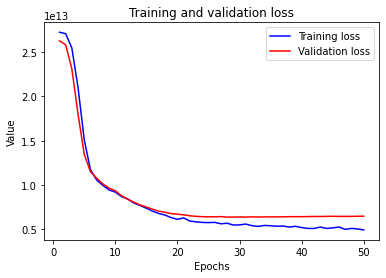

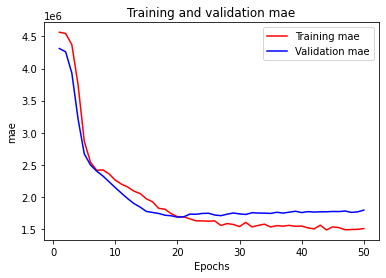

In [ ]:
def draw_graph(history):

    loss_values = history["loss"]
    validation_loss_values = history["val_loss"]
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, validation_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    plt.clf()
 
    mae = history['mae']
    val_mae = history['val_mae']
    plt.plot(epochs, mae, 'r', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

draw_graph(history)

In [ ]:
pred = model.predict(x_test)
predicted_x = np.reshape(pred, (pred.shape[0]))
predicted_y = np.reshape(y_test, (y_test.shape[0]))

In [ ]:
for test_index in range(20):
  print("Predict:", predicted_x[test_index],", True:",predicted_y.values[test_index])

Predict: 3825127.2 , True: 2792031.0
Predict: 4313077.5 , True: 3570392.0
Predict: 5377573.5 , True: 3600467.0
Predict: 6426598.5 , True: 5017319.0
Predict: 5223906.5 , True: 3752885.0
Predict: 3119081.0 , True: 2675511.0
Predict: 5227059.0 , True: 4705945.0
Predict: 3733811.0 , True: 2993069.0
Predict: 2491046.5 , True: 1734634.0
Predict: 4967544.5 , True: 4554237.0
Predict: 6096719.5 , True: 6941173.0
Predict: 5707036.5 , True: 5906596.0
Predict: 5078671.0 , True: 4882985.0
Predict: 3220902.5 , True: 2055379.0
Predict: 3703927.5 , True: 3778621.0
Predict: 4163171.2 , True: 2344689.0
Predict: 5563918.5 , True: 13575224.0
Predict: 3356006.0 , True: 2954086.0
Predict: 2792049.5 , True: 1999097.0
Predict: 4603428.0 , True: 4136425.0


Предсказания и подсчет коэффициента корреляции

In [ ]:
cc = np.corrcoef(predicted_x, predicted_y)
ccc = cc[0][1]
print(f'Correlation Coefficient: {ccc}')

Correlation Coefficient: 0.5364190133190083


**Keras Tuner**

In [ ]:
def build_model(hp):
  hidden_layers = hp.Choice('hidden_layers', values=[1,2,3])
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model = Sequential()
  model.add(Dense(units=hp.Int('units',min_value=128,max_value=512,step=32),activation=activation_choice, input_shape=(x_train.shape[1], )))
  model.add(Dropout(0.3))
  for i in range(hidden_layers):
    model.add(Dense(units=hp.Int(f'layer_{i}_units_',min_value=64//(i+1), max_value=256//(i+1),step=16//(i+1)),activation=activation_choice))
  model.add(Dense(1))  
  model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
  return model

In [ ]:
def find_best(x_train, y_train):
  # создаю тюнер, который сможет подобрать оптимальную архитектуру модели
  tuner = RandomSearch(build_model, objective="loss", max_trials=30, executions_per_trial=1)
  print("\n\n\n")
  # начинается автоматический подбор гиперпараметров
  print('[INFO] start searching')
  tuner.search(x_train, y_train, batch_size=1, epochs=50, validation_split=0.3)
  # выбираем лучшую модель
  print("\n\n\nRESULTS SUMMARY")
  tuner.results_summary()
  print("\n\n\n")
  # получаем лучшую модель
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model
  

best_model = find_best(x_train, y_train)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json




[INFO] start searching
INFO:tensorflow:Oracle triggered exit



RESULTS SUMMARY









HERE IS THE BEST MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5376      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                12384     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               11640     
_________________________________________________________________
dense_3 (Dense)              (None, 70)                8470      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 71        
Total params: 37,941
Trainable params: 37,941
Non-trainable params: 0
___________________

In [ ]:
best_history = best_model.fit(x_train, y_train, epochs=50, batch_size=1, validation_split=0.3)
best_history = best_history.history
print("[INFO] Training has been finished")

Epoch 1/50
76/76 [==============================] - 0s 5ms/step - loss: 27252236484608.0000 - mae: 4565798.5000 - val_loss: 26292785250304.0000 - val_mae: 4312757.0000
Epoch 2/50
76/76 [==============================] - 0s 2ms/step - loss: 27198855577600.0000 - mae: 4560652.5000 - val_loss: 26181418090496.0000 - val_mae: 4300134.0000
Epoch 3/50
76/76 [==============================] - 0s 2ms/step - loss: 26908093841408.0000 - mae: 4528342.0000 - val_loss: 25740353470464.0000 - val_mae: 4249823.0000
Epoch 4/50
76/76 [==============================] - 0s 2ms/step - loss: 25928132460544.0000 - mae: 4419864.5000 - val_loss: 24285739483136.0000 - val_mae: 4078387.5000
Epoch 5/50
76/76 [==============================] - 0s 2ms/step - loss: 23871650529280.0000 - mae: 4160009.7500 - val_loss: 21833365585920.0000 - val_mae: 3762795.7500
Epoch 6/50
76/76 [==============================] - 0s 2ms/step - loss: 20180526694400.0000 - mae: 3643752.7500 - val_loss: 18241369931776.0000 - val_mae: 32708

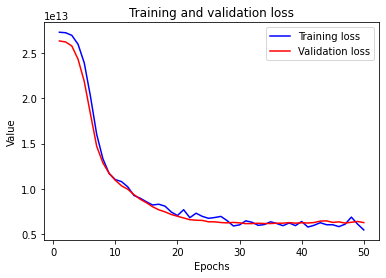

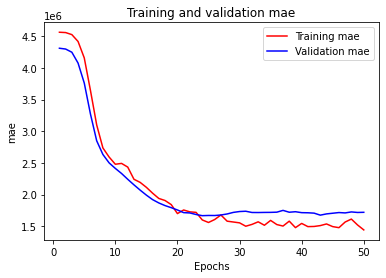

In [ ]:
draw_graph(best_history)

In [ ]:
kpredicted_x = best_model.predict(x_test)
kpredicted_x = np.reshape(kpredicted_x, (kpredicted_x.shape[0]))

In [ ]:
for test_index in range(20):
  print("K:", kpredicted_x[test_index], " M:", predicted_x[test_index], " True:",predicted_y.values[test_index])

K: 3411005.8  M: 3825127.2  True: 2792031.0
K: 3666685.5  M: 4313077.5  True: 3570392.0
K: 5084240.5  M: 5377573.5  True: 3600467.0
K: 5206705.0  M: 6426598.5  True: 5017319.0
K: 4212388.5  M: 5223906.5  True: 3752885.0
K: 3216915.0  M: 3119081.0  True: 2675511.0
K: 5190111.5  M: 5227059.0  True: 4705945.0
K: 3468896.8  M: 3733811.0  True: 2993069.0
K: 1977804.8  M: 2491046.5  True: 1734634.0
K: 4819897.0  M: 4967544.5  True: 4554237.0
K: 5205379.0  M: 6096719.5  True: 6941173.0
K: 5177078.0  M: 5707036.5  True: 5906596.0
K: 6531215.5  M: 5078671.0  True: 4882985.0
K: 2642437.0  M: 3220902.5  True: 2055379.0
K: 3574326.8  M: 3703927.5  True: 3778621.0
K: 3852714.5  M: 4163171.2  True: 2344689.0
K: 5949985.0  M: 5563918.5  True: 13575224.0
K: 3768683.2  M: 3356006.0  True: 2954086.0
K: 3145551.5  M: 2792049.5  True: 1999097.0
K: 4880522.5  M: 4603428.0  True: 4136425.0


In [ ]:
KK = np.corrcoef(kpredicted_x, y_test)
KK = KK[0][1]
print(f'My model Correlation Coefficient: {ccc}')
print(f'Keras Correlation Coefficient: {KK}')

My model Correlation Coefficient: 0.5364190133190083
Keras Correlation Coefficient: 0.5939583344923584
